# Elo ratings for the Swedish hockey league, SHL

In [15]:
%pylab inline
import pandas as pd

pylab.rcParams['figure.figsize'] = (16.25, 10.)

Populating the interactive namespace from numpy and matplotlib


In [16]:
from glob import glob
df = pd.concat([pd.read_csv(path, encoding='utf-8') for path in glob('data/*.csv')])
df.sort(['Season', 'Game type', 'Date', 'Home', 'Visitor'], inplace=True)

## Elo calculation

* Initial rating: 1500
* K: 20

In [17]:
from collections import defaultdict

def elo(df, initial_rating=1500., K=20, home_team_advantage=0):
    ratings = defaultdict(lambda: initial_rating)
    
    for x, game in df.iterrows():
        [date, home, away, home_goals, away_goals, decider, season] = game[['Date', 'Home', 'Visitor', 'HS', 'VS', 'Dec', 'Season']]
        
        if decider in ['OT', 'SO']:
            continue
            
        RA = ratings[home]
        RB = ratings[away]
        
        # TODO(liesen): Goal difference multiplier
        
        # Calculate new rankings
        SA = (cmp(home_goals, away_goals) + 1) / 2.  # Win=1, Draw=.5, Loss=0
        SB = (cmp(away_goals, home_goals) + 1) / 2.
        EA = 1. / (1 + 10**((RB - (RA + home_team_advantage)) / 400.))
        EB = 1. / (1 + 10**(((RA + home_team_advantage) - RB) / 400.))
        newRA = RA + K * (SA - EA)
        newRB = RB + K * (SB - EB)
        
        # Update rankings
        ratings[home] = newRA
        ratings[away] = newRB
        
        yield {'Date': date, 'Team': home, 'Rating': newRA, 'Season': season}
        yield {'Date': date, 'Team': away, 'Rating': newRB, 'Season': season}

## Elo ratings for the 2014/15 season

Check *Home team advantage* notebook for calculation of `home_team_advantage`.

In [18]:
elos_2014 = pd.DataFrame.from_records(elo(df[(df['Season'] == 2014) & (df['Game type'] == 'SHL')], home_team_advantage=75))
elos_2014 = pd.pivot_table(elos_2014, index='Date', columns='Team', values='Rating', aggfunc=np.nanmean)
elos_2014 = elos_2014.ffill()

### Team rankings

In [19]:
rankings_2014 = elos_2014.ix[-1].sort(inplace=False, ascending=False)
rankings_2014

Team
SAIK    1600.207452
VLH     1561.194682
FHC     1544.826761
LHC     1543.287823
HV71    1528.605180
ÖHK     1526.588296
FBK     1517.159534
LHF     1490.445657
BIF     1451.942371
DIF     1442.226695
LIF     1401.371539
MODO    1392.144010
Name: 2015-03-05, dtype: float64

## Plot

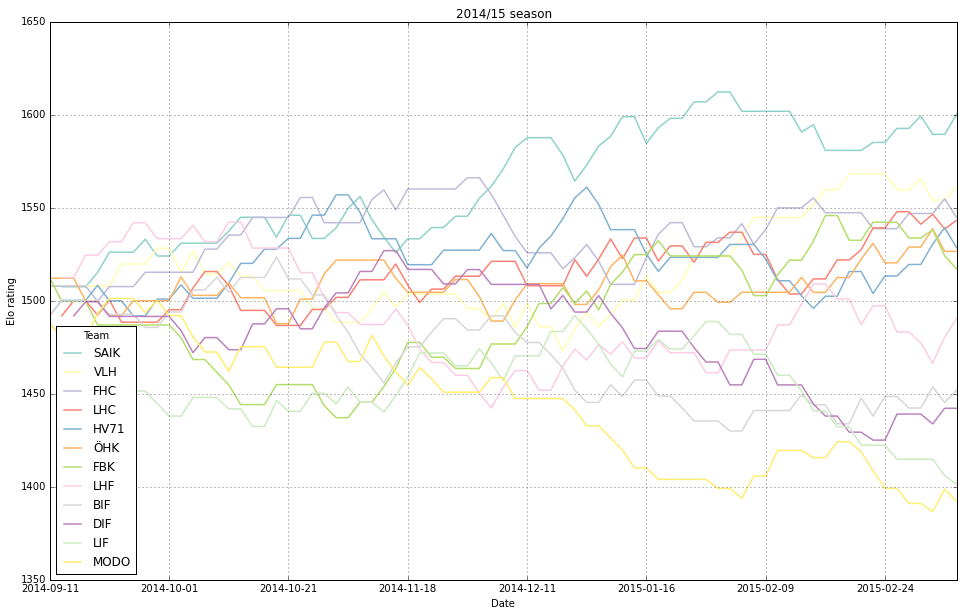

In [20]:
_ = elos_2014[rankings_2014.index].ffill().plot(title='2014/15 season', cmap='Set3', linewidth=1.5).set_ylabel('Elo rating')

## All time (since 2006) Elo ratings

In [21]:
elos_all = pd.DataFrame.from_records(elo(df[df['Game type'] == 'SHL'], home_team_advantage=50))
elos_all = pd.pivot_table(elos_all, index='Date', columns='Team', values='Rating', aggfunc=np.nanmean)

### Current rankings

In [22]:
rankings_all = elos_all.ffill().ix[-1].sort(inplace=False, ascending=False)
rankings_all

Team
SAIK    1681.199942
FHC     1614.498445
VLH     1613.019387
LHC     1584.641943
FBK     1572.254903
HV71    1565.190231
ÖHK     1547.602707
LHF     1535.115092
BIF     1495.526553
MIK     1471.501387
SSK     1470.183050
DIF     1464.482189
LIF     1443.346392
MODO    1427.100645
AIK     1416.736904
IFM     1391.778752
TIK     1372.620439
RBK     1333.201039
Name: 2015-03-05, dtype: float64

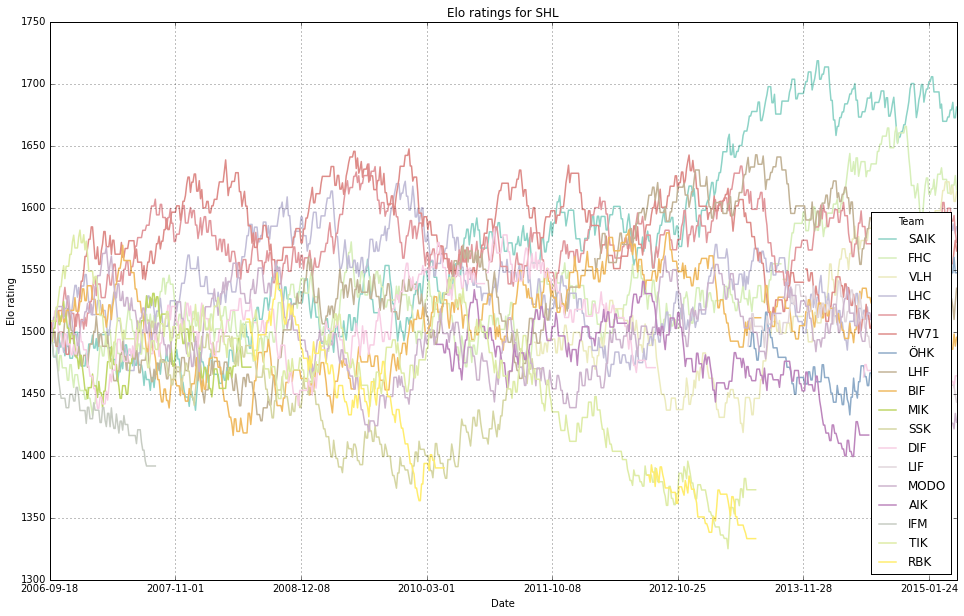

In [23]:
_ = elos_all[rankings_all.index].ffill(limit=7).plot(title='Elo ratings for SHL', cmap='Set3', linewidth=1.5).set_ylabel('Elo rating')

### King of the Hill

In [24]:
king_of_the_hill = pd.DataFrame({'Team': elos_all.idxmax(axis=1), 'Rating': elos_all.max(axis=1)})

Find the team who has been king of the hill the most times.

In [25]:
king_of_the_hill.groupby('Team').count().sort('Rating', inplace=False, ascending=False).head()

,Rating
Team,
HV71,191
SAIK,157
FBK,101
LHC,71
FHC,55


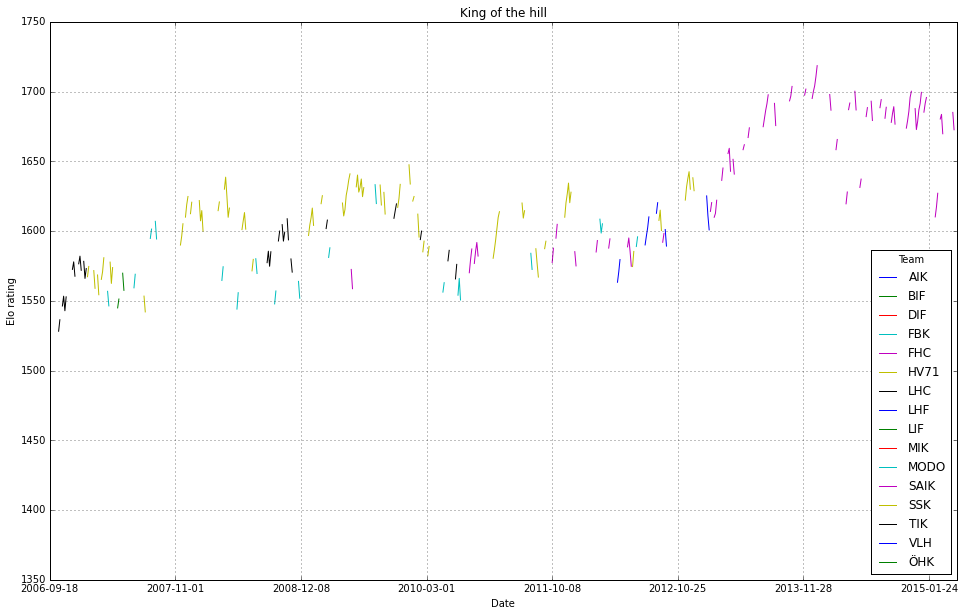

In [26]:
_ = king_of_the_hill \
        .reset_index() \
        .pivot(index='Date', columns='Team', values='Rating') \
        .plot(title='King of the hill') \
        .set_ylabel('Elo rating')

#### Longest time at the top

In [27]:
import itertools
pd.DataFrame.from_records([{'Team': team, 'Length': period.max() - period.min(), 'Start': period.min(), 'End': period.max()}
                           for team, period in ((team, pd.DatetimeIndex([x[0] for x in group]))
                                                       for team, group in itertools.groupby(king_of_the_hill.iterrows(), lambda x: x[1]['Team']))]) \
    .sort('Length', ascending=False) \
    .head(10)

,End,Length,Start,Team
172,2009-09-28,216 days,2009-02-24,HV71
347,2012-09-15,196 days,2012-03-03,LHF
114,2008-09-18,196 days,2008-03-06,HV71
477,2014-09-11,187 days,2014-03-08,FHC
105,2008-02-18,16 days,2008-02-02,HV71
176,2009-10-22,16 days,2009-10-06,HV71
338,2012-02-14,14 days,2012-01-31,SAIK
90,2008-01-03,14 days,2007-12-20,HV71
506,2014-12-11,13 days,2014-11-28,SAIK
509,2015-01-10,13 days,2014-12-28,SAIK
